# Isotherm model fitting

In this notebook we'll attempt to fit isotherms using the included models.
First, make sure the data is imported by running the import notebook.

In [1]:
# import isotherms
%run import.ipynb

# Then the modelling module
import pygaps.modelling as pgm

Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric enthalpy calculation


## Selecting models

Instead of recreating isotherms, we'll fit PointIsotherms with the `model_iso`
function. Let's select one of the isotherms and attempt to model it with the
Double Site Langmuir model. It is worth noting that, if the branch is not
selected, the model will automatically select the adsorption branch.

Attempting to model using DSLangmuir.
Model DSLangmuir success, RMSE is 0.339
DSLangmuir isotherm model.
RMSE = 0.3391
Model parameters:
	n_m1 = 4.736
	K1 = 243.3
	n_m2 = 9.218
	K2 = 5.912e+04
Model applicable range:
	Pressure range: 6.04e-07 - 0.96
	Loading range: 0.257 - 14.7



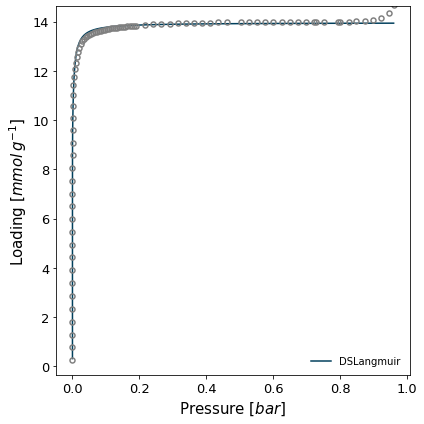

In [2]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='UiO-66(Zr)')
model_iso = pgm.model_iso(isotherm, model='DSLangmuir', verbose=True)
print(model_iso.model)

The original model is therefore reasonably good, even if there are likely
microporous filling steps at low pressure which are not fully captured. It's
important to note that the ModelIsotherm has almost all the properties of a
PointIsotherm and can be used for all calculations. For example:

Langmuir area: a = 1361 m2/g
Minimum pressure point is 0.0482 and maximum is 0.851
The Langmuir constant is: K = 738
Amount Langmuir monolayer is: n = 0.014 mol/g
The slope of the Langmuir fit: s = 71.7
The intercept of the Langmuir fit: i = 0.0971



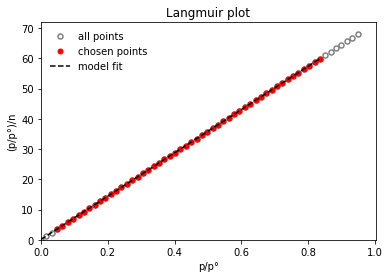

In [3]:
import pygaps.characterisation as pgc
res = pgc.area_langmuir(model_iso, verbose=True)

Let's now apply the same model to another isotherm.

In [4]:
isotherm = next(i for i in isotherms_n2_77k if i.material == 'SiO2')
try:
    model = pgm.model_iso(
        isotherm,
        model='DSLangmuir',
        verbose=True,
    )
except Exception as e:
    print(e)

Attempting to model using DSLangmuir.
Fitting routine for DSLangmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m1': 8.584125, 'K1': 18.630173351237513, 'n_m2': 8.584125, 'K2': 27.94526002685627}



We can increase the number of minimisation iterations manually, by specifying an
`optimisation_params` dictionary which will be passed to the relevant Scipy
routine. However, the model chosen may not fit the data, no matter how much we
attempt to minimise the function, as seen below.

In [5]:
isotherm = next(i for i in isotherms_n2_77k if i.material == 'SiO2')
try:
    model = pgm.model_iso(
        isotherm,
        model='DSLangmuir',
        verbose=True,
        optimization_params=dict(max_nfev=1e3),
    )
except Exception as e:
    print(e)

Attempting to model using DSLangmuir.
Fitting routine for DSLangmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m1': 8.584125, 'K1': 18.630173351237513, 'n_m2': 8.584125, 'K2': 27.94526002685627}



## Guessing models

We also have the option of guessing a model instead. This option will calculate
model fits with a **selection** of the available models, and select the one with
the smallest root mean square. Let's try this on the previous isotherm.

Attempting to model using Henry.
Model Henry success, RMSE is 1.56
Attempting to model using Langmuir.
Modelling using Langmuir failed.

Fitting routine for Langmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m': 17.16825, 'K': 46.575433378093784}

Attempting to model using DSLangmuir.
Modelling using DSLangmuir failed.

Fitting routine for DSLangmuir failed with error:
	The maximum number of function evaluations is exceeded.
Try a different starting point in the nonlinear optimization
by passing a dictionary of parameter guesses, param_guess, to the constructor.
Default starting guess for parameters:
{'n_m1': 8.584125, 'K1': 18.630173351237513, 'n_m2': 8.584125, 'K2': 27.94526002685627}

Attempting to model using DR.
Model DR success, RMSE is 2.04
Attempting to model using

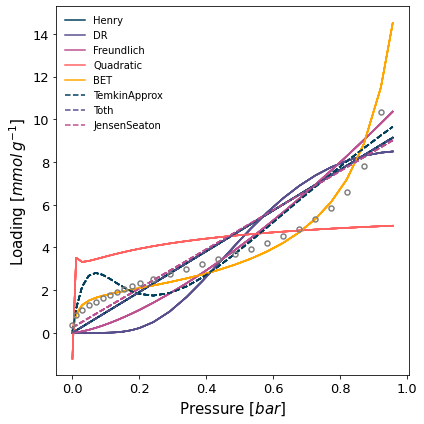

In [6]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='SiO2')

model = pgm.model_iso(isotherm, model='guess', verbose=True)

We can see that most models failed or have a poor fit, but the BET model has been correctly identified as the best fitting one.

## Other options

We can also attempt to model the desorption branch of an isotherm, and provide a
manual list of models to attempt to guess, including specialised models which
are not usually included in the guessing routine.

Attempting to model using GAB.
Model GAB success, RMSE is 0.415
Attempting to model using BET.
Model BET success, RMSE is 0.415
Attempting to model using Langmuir.
Model Langmuir success, RMSE is 0.87
Best model fit is GAB.


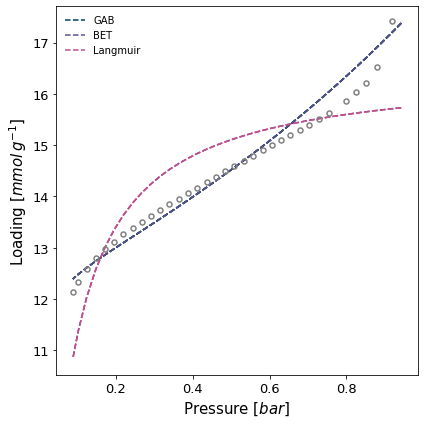

In [7]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='Takeda 5A')

model = pgm.model_iso(isotherm, model=['GAB', 'BET', 'Langmuir'], branch='des', verbose=True)

We can manually set bounds on fitted parameters by using a ``param_bounds`` dictionary, passed to the ModelIsotherm.

Attempting to model using Langmuir.
Model Langmuir success, RMSE is 3.56


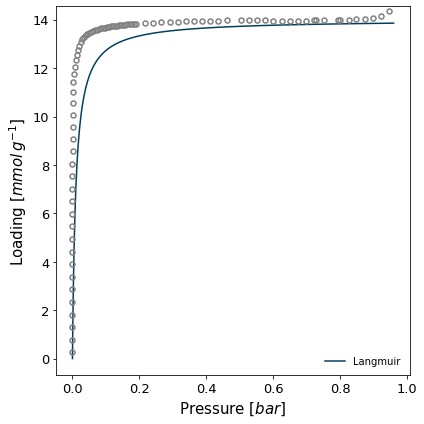

In [8]:
isotherm = next(i for i in isotherms_n2_77k if i.material == 'UiO-66(Zr)')

model = pgm.model_iso(
    isotherm,
    model='Langmuir',
    param_bounds={
        "n_m": [0., 14],
        "K": [0., 100],
    },
    verbose=True,
)

Just because a the minimisation has successfully produced a model that **does
NOT mean** that the model is accurate. For example, trying to model the MCM-41
sample with a Langmuir model does not throw any errors but it is obvious that
the model is not representative of the mesoporous condensation in the pores.

Attempting to model using DSLangmuir.
Model DSLangmuir success, RMSE is 0.644


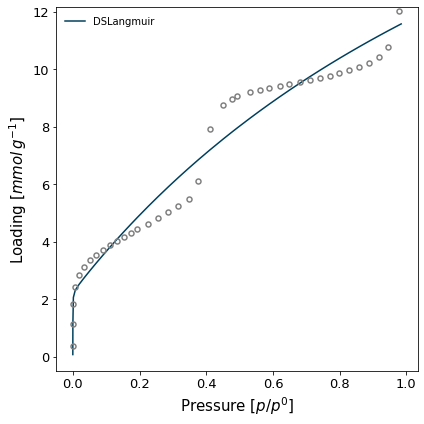

In [9]:
isotherm = next(i for i in isotherms_n2_77k if i.material=='MCM-41')

model = pgm.model_iso(isotherm, model="DSLangmuir", verbose=True)

## Creating ModelIsotherms

ModelIsotherms do not need to be created from a PointIsotherm. They can also be
created from raw data, or from pre-generated models. To create one from scratch:

<AxesSubplot:xlabel='Pressure [$bar$]', ylabel='Loading [$mmol\\/g^{-1}$]'>

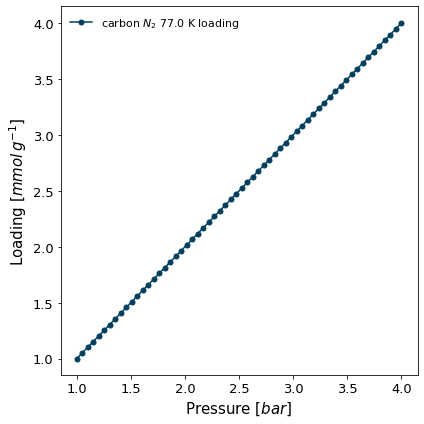

In [10]:
import pygaps as pg
model_iso = pg.ModelIsotherm(
    material='carbon',
    adsorbate='N2',
    temperature=77,
    pressure=[1,2,3,4],
    loading=[1,2,3,4],
    model='Henry',
)
model_iso.plot()

Or if a model is to be created from pre-defined parameters, one can do:

<AxesSubplot:xlabel='Pressure [$bar$]', ylabel='Loading [$mmol\\/g^{-1}$]'>

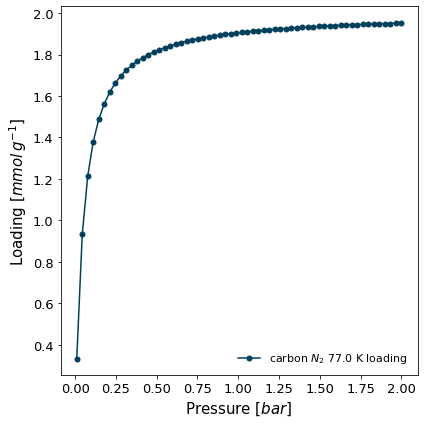

In [11]:
model = pgm.get_isotherm_model(
    'Langmuir',
    params={
        'parameters': {
            "K": 20,
            "n_m": 2
        },
        'pressure_range': (0.01, 2),
    },
)
model_iso = pg.ModelIsotherm(
    material='carbon',
    adsorbate='N2',
    temperature=77,
    model=model,
)
model_iso.plot()

More info can be found in the [manual section](https://pygaps.readthedocs.io/en/master/manual/modelling.html).